# InfoGAN
[InfoGAN](https://arxiv.org/abs/1606.03657) is an information-theoretic extension to the simple Generative Adversarial Networks that is able to learn disentangled representations in a completely unsupervised manner. What this means is that InfoGAN successfully disentangle wrirting styles from digit shapes on th MNIST dataset and discover visual concepts such as hair styles and gender on the CelebA dataset. To achieve this an information-theoretic regularization is added to the loss function that enforces the maximization of mutual information between latent codes, c, and the generator distribution G(z, c).

**You can see more detail in My [Github](https://github.com/cjfghk5697/Paper_Implementation/tree/main/InfoGAN) repositories. And SVHN dataset was implementation. dataset **


# Imports

In [8]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import time
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset,DataLoader

In [9]:
params={
    'epochs':100,
    'image_size':64,
    'batch_size':256,
    'num_workers':2,
    'nz':74,
    'nc':3,
    'ngf':64,
    'ndf':64,
    'lr':1e-3,
    'beta1':0.5
}


# Data
The dataset have Sandal, Shoe, Boot classes. We try to the generate image about 3 classes.

In [10]:
states=['Boot','Sandal','Shoe']
image_files=[[os.path.join('/kaggle/input/shoe-vs-sandal-vs-boot-dataset-15k-images/Shoe vs Sandal vs Boot Dataset',state,x) for x in os.listdir(os.path.join('/kaggle/input/shoe-vs-sandal-vs-boot-dataset-15k-images/Shoe vs Sandal vs Boot Dataset',state))] for state in states]

In [11]:
images_paths=[]
for i in range(3):
  for j in range(len(image_files[i])):
    current=image_files[i]
    images_paths.append(current[j])

In [12]:
class CustomDataset(nn.Module):
  def __init__(self,image_paths,To_tensor):
    super(CustomDataset,self).__init__()
    self.image_paths=image_paths
    self.To_tensor=To_tensor

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self,x):
    image=cv2.imread(self.image_paths[x])
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    imgae=np.asarray(image,dtype=np.uint8)

    image=Image.fromarray(image.astype(np.uint8))
    image=self.To_tensor(image)

    return image.clone()

# Transformation
Our model input image size 64. So we resize image and check training image.

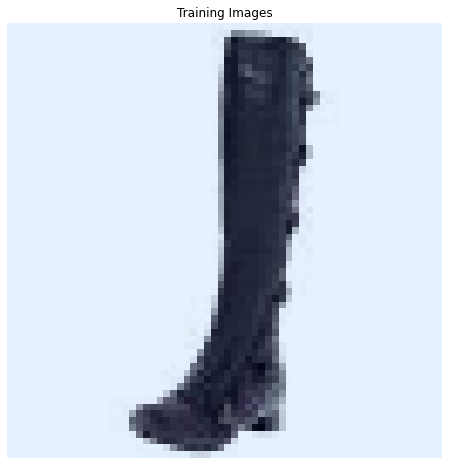

In [13]:
To_tensor=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((params['image_size'],params['image_size'])),
    transforms.Normalize(        
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]),
])

dataset=CustomDataset(images_paths,To_tensor)

dataloader=DataLoader(dataset,
                      batch_size=params['batch_size'],
                      shuffle=True,
                      num_workers=params['num_workers'],
                      pin_memory=True
)

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Model


**G_conv** : Convolution in Generator model.<br>
**D_conv** : Convolution in Discriminator model. <br>
**DHead** : DHead apply sigmoid from Discriminator output. <br>
**QHead** : QHead make mu(population mean), var(variance), disc_logits <br>
**Generator** : Generate image <br>
**Discriminator** : Discriminator image

In [14]:

class G_conv(nn.Module):
    def __init__(self,in_channels,out_channels,*args):
        super(G_conv,self).__init__()
        self.conv=nn.Sequential(
            nn.ConvTranspose2d( in_channels,out_channels,*args, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
        )
    def forward(self,x):
        return self.conv(x)

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.main=nn.Sequential(
            G_conv(params['nz'],params['ngf']*8,4,1,0),
            G_conv(params['ngf']*8,params['ngf']*4,4,2,1),
            G_conv(params['ngf']*4,params['ngf']*2,4,2,1),
            G_conv(params['ngf']*2,params['ngf'],4,2,1),

            nn.ConvTranspose2d(params['ngf'],params['nc'],4,2,1,bias=False),
            nn.Tanh()
        )
    
    def forward(self,x):
        return self.main(x)

class D_conv(nn.Module):
    def __init__(self,in_channels,out_channels,*args):
        super(D_conv,self).__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(in_channels, out_channels, *args, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self,x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.main=nn.Sequential(
            nn.Conv2d(params['nc'],params['ndf'],4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            D_conv(params['ndf'],params['ndf']*2,4,2,1),
            D_conv(params['ndf']*2,params['ndf']*4,4,2,1),
            D_conv(params['ndf']*4,params['ndf']*8,4,2,1),
            nn.Conv2d(params['ndf']*8,params['ndf']*8,4,1,0,bias=False),
        )

    def forward(self,x):
        return self.main(x)

class DHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv=nn.Conv2d(params['ndf']*8,1,1,bias=False)
    
    def forward(self,x):
        x=torch.sigmoid(self.conv(x))
        return x
class QHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(params['ndf']*8,128,1,bias=False)
        self.bn1=nn.BatchNorm2d(128)
        self.leakyrelu=nn.LeakyReLU(0.2,inplace=True)
        self.conv_disc=nn.Conv2d(128,10,1)
        self.conv_mu=nn.Conv2d(128,2,1)
        self.conv_var=nn.Conv2d(128,2,1)

    def forward(self,x):
        x=self.leakyrelu(self.bn1(self.conv1(x)))
        
        disc_logits=self.conv_disc(x).squeeze()

        mu=self.conv_mu(x).squeeze()
        var=torch.exp(self.conv_var(x).squeeze())

        return disc_logits,mu,var

In [15]:
def weights_init(m):
    if isinstance(m,nn.Conv2d):
        nn.init.normal_(m.weight.data,0.0,0.02)
    elif isinstance(m,nn.BatchNorm2d):
        nn.init.normal_(m.weight.data,1.0,0.02)
        nn.init.constant_(m.bias.data,0)

class NormalNLLLoss:
    def __call__(self,x,mu,var):
        logli=-0.5*(var.mul(2*np.pi)+1e-6).log()-(x-mu).pow(2).div(var.mul(2.0)+1e-6)
        nll=-(logli.sum(1).mean())

        return nll

def noise_sample(n_dis_c,dis_c_dim,n_con_c,n_z,batch_size,device):
    z=torch.randn(batch_size,n_z,1,1,device=device)

    idx=np.zeros((n_dis_c,batch_size))
    if n_dis_c !=0:
        dis_c=torch.zeros(batch_size,n_dis_c,dis_c_dim,device=device)

        for i in range(n_dis_c):
            idx[i]=np.random.randint(dis_c_dim,size=batch_size)
            dis_c[torch.arange(0,batch_size),i,idx[i]]=1.0
        
        dis_c=dis_c.view(batch_size,-1,1,1)

    if n_con_c!=0:
        con_c=torch.rand(batch_size,n_con_c,1,1,device=device)*2-1

    noise=z

    if n_dis_c!=0:
        noise=torch.cat((z,dis_c),dim=1)
    if n_con_c!=0:
        noise=torch.cat((noise,con_c),dim=1)
    return noise,idx

# Train

In [ ]:
params['num_z']=62
params['num_dis_c']=1
params['dis_c_dim']=10
params['num_con_c']=2

device=torch.device("cuda" if torch.cuda.is_available() else 'cpu')

netG=Generator().to(device)
discriminator=Discriminator().to(device)
netD=DHead().to(device)
netQ=QHead().to(device)

netG.apply(weights_init)
netD.apply(weights_init)
netQ.apply(weights_init)

criterionD=nn.BCELoss()
criterionQ_dis=nn.CrossEntropyLoss()
criterionQ_con=NormalNLLLoss()

fixed_noise=torch.randn(64,params['nz'],1,1,device=device)


optimD=optim.Adam([{'params': discriminator.parameters()}, {'params': netD.parameters()}],lr=params['lr'],betas=(params['beta1'],0.999))
optimG=optim.Adam([{'params': netG.parameters()}, {'params': netQ.parameters()}],lr=params['lr'],betas=(params['beta1'],0.999))

#fixed noise
z = torch.randn(100, params['num_z'], 1, 1, device=device)
fixed_noise = z
if(params['num_dis_c'] != 0):
    idx = np.arange(params['dis_c_dim']).repeat(10)
    dis_c = torch.zeros(100, params['num_dis_c'], params['dis_c_dim'], device=device)
    for i in range(params['num_dis_c']):
        dis_c[torch.arange(0, 100), i, idx] = 1.0

    dis_c = dis_c.view(100, -1, 1, 1)

    fixed_noise = torch.cat((fixed_noise, dis_c), dim=1)

if(params['num_con_c'] != 0):
    con_c = torch.rand(100, params['num_con_c'], 1, 1, device=device) * 2 - 1
    fixed_noise = torch.cat((fixed_noise, con_c), dim=1)

real_label=1.
fake_label=0.

img_list=[]
G_losses=[]
D_losses=[]

iters=0
print('start')
for epoch in range(params['epochs']):
    epoch_start_time = time.time()
    for i, data in enumerate(dataloader,0):
        b_size=data.size(0)
        real_data=data.to(device)

        optimD.zero_grad()
        label=torch.full((b_size,),real_label,device=device)
        output1=discriminator(real_data)
        probs_real=netD(output1).view(-1)
        loss_real=criterionD(probs_real,label)
        loss_real.backward()

        label.fill_(fake_label)
        noise,idx=noise_sample(params['num_dis_c'],params['dis_c_dim'],params['num_con_c'],params['num_z'],b_size,device)
        fake_data=netG(noise)
        output2=discriminator(fake_data.detach())
        probs_fake=netD(output2).view(-1)
        loss_fake=criterionD(probs_fake,label)

        loss_fake.backward()

        D_loss=loss_real+loss_fake
        optimD.step()
        optimG.zero_grad()

        output=discriminator(fake_data)
        label.fill_(real_label)
        probs_fake=netD(output).view(-1)
        gen_loss=criterionD(probs_fake,label)

        q_logits,q_mu,q_var=netQ(output)
        target=torch.LongTensor(idx).to(device)

        dis_loss=0
        for j in range(params['num_dis_c']):
            dis_loss+=criterionQ_dis(q_logits[:,j*10:j*10+10],target[j])

        con_loss=0
        if params['num_con_c']!=0:
            con_loss=criterionQ_con(noise[:,params['num_z']+params['num_dis_c']*params['dis_c_dim']:].view(-1,params['num_con_c']),q_mu,q_var)*0.1
        G_loss=gen_loss+dis_loss+con_loss
        G_loss.backward()
        optimG.step()
        if i != 0 and i%100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch+1, params['epochs'], i, len(dataloader), 
                    D_loss.item(), G_loss.item()))

        # Save the losses for plotting.
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

        iters += 1
    epoch_time = time.time() - epoch_start_time
    print("Time taken for Epoch %d: %.2fs" %(epoch + 1, epoch_time))
    
    # Generate image after each epoch to check performance of the generator. Used for creating animated gif later.
    with torch.no_grad():
        gen_data = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True))

    # Generate image to check performance of generator.
    if((epoch+1) == 1 or (epoch+1) == params['epochs']/2):
        with torch.no_grad():
            gen_data = netG(fixed_noise).detach().cpu()
        plt.figure(figsize=(10, 10))
        plt.axis("off")
        plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
        plt.savefig("Epoch_%d {}".format('MNIST') %(epoch+1))
        plt.close('all')



start
Time taken for Epoch 1: 64.01s
Time taken for Epoch 2: 24.91s
Time taken for Epoch 3: 24.99s
Time taken for Epoch 4: 24.56s
Time taken for Epoch 5: 25.27s
Time taken for Epoch 6: 25.23s
Time taken for Epoch 7: 25.52s
Time taken for Epoch 8: 24.64s
Time taken for Epoch 9: 24.87s
Time taken for Epoch 10: 25.71s
Time taken for Epoch 11: 25.23s
Time taken for Epoch 12: 25.60s
Time taken for Epoch 13: 24.80s
Time taken for Epoch 14: 26.77s
Time taken for Epoch 15: 25.14s
Time taken for Epoch 16: 25.56s
Time taken for Epoch 17: 25.72s
Time taken for Epoch 18: 25.21s
Time taken for Epoch 19: 25.40s
Time taken for Epoch 20: 25.65s
Time taken for Epoch 21: 25.58s
Time taken for Epoch 22: 25.47s
Time taken for Epoch 23: 24.79s
Time taken for Epoch 24: 26.72s
Time taken for Epoch 25: 24.94s
Time taken for Epoch 26: 25.43s
Time taken for Epoch 27: 24.85s
Time taken for Epoch 28: 24.98s
Time taken for Epoch 29: 25.33s
Time taken for Epoch 30: 25.26s
Time taken for Epoch 31: 25.80s
Time taken 

# Result

|Generation GIF|Generation Image|
|------|--------|
|<img src='https://raw.githubusercontent.com/cjfghk5697/Code_Share/main/GAN/Shoe%20vs%20Sandal%20vs%20Boot%20Image%20Dataset/results/results.gif' alt="results.gif"/>|<img src='https://raw.githubusercontent.com/cjfghk5697/Code_Share/main/GAN/Shoe%20vs%20Sandal%20vs%20Boot%20Image%20Dataset/results/7.png' alt="results.gif"/>|



**Training Loss Curve**

In [ ]:
plt.figure()
plt.plot(G_losses, color='blue', marker=',', label='G')
plt.plot(D_losses, color='orange', marker=',', label='D')
plt.title('Generation and Discriminator loss')
plt.legend()
plt.show()